# EEG Blink Detection Single File
Detecting blink frequency and duration in a single EEG file.

In [ ]:
# %reload_ext autoreload
# %autoreload 2
import logging
import os

log = lambda msg: logging.info(msg)


# Load data

In [ ]:
input_file = "C:\\dev\\play\\brainwave-data\\2024-12-08-21-23-50\\raw.fif"
input_file_without_ext = os.path.splitext(input_file)[0]


In [ ]:
from convert import load_mne_file
raw, input_file_without_ext, mne_filtered = load_mne_file(log, input_file)


# Find blinks

Start sample: 7500
End sample: 15000
Epoch data shape: (7500,)


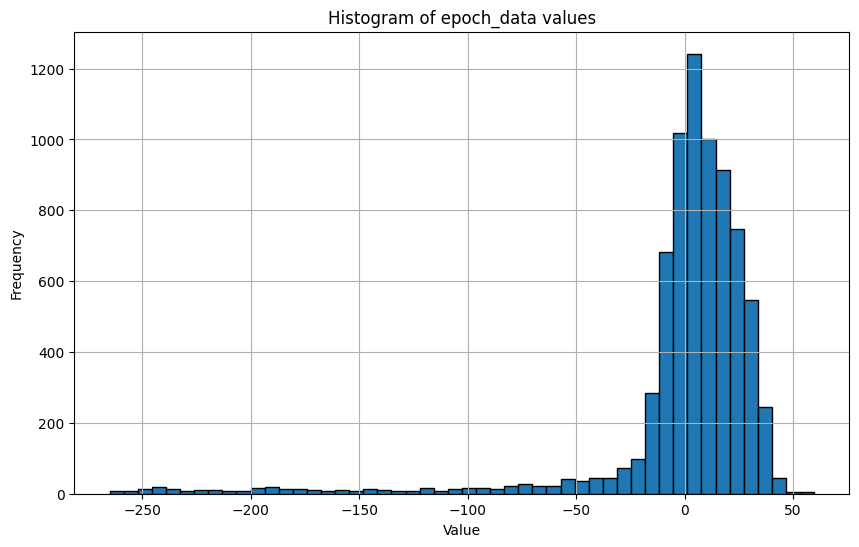

In [29]:
def extract_epoch(epoch_idx: int, raw):
    sfreq = 250
    start_sample = epoch_idx * (30 * sfreq)
    end_sample = start_sample + (30 * sfreq)
    
    print("Start sample:", start_sample)
    print("End sample:", end_sample)
    
    # Extract the data for the specified epoch
    actual_raw = raw.get_data(units=dict(eeg="uV")) #/ 1_000_000
    epoch_data = actual_raw[:, start_sample:end_sample].flatten()
    
    # Print the shape of the extracted data
    print("Epoch data shape:", epoch_data.shape)
    
    return epoch_data

epoch_data = extract_epoch(1, mne_filtered)

import matplotlib.pyplot as plt

# Assuming epoch_data is already defined
plt.figure(figsize=(10, 6))
plt.hist(epoch_data.flatten(), bins=50, edgecolor='black')
plt.title('Histogram of epoch_data values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [43]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

threshold=-75
max_duration=0.5

epoch_data = extract_epoch(1, mne_filtered)

softened = gaussian_filter1d(epoch_data, 1)

# Detect threshold crossings
crossings = np.where(softened < threshold)[0]
crossings



Start sample: 7500
End sample: 15000
Epoch data shape: (7500,)


array([  42,   43,   44,   45,   46,   47,   48,   49,   50,   51,   52,
         53,   54,   55,   56,   57,   58,   59,   60,   61,   62,   63,
         64,   65,   66,   67,   68,   69,   70,   71,   72,   73,   74,
         75,   76,   77,   78,   79,   80,   81,   82, 1940, 1941, 1942,
       1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 2730, 2731, 2732, 2733, 2734, 2735,
       2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746,
       2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757,
       2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768,
       2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779,
       2780, 2781, 2782, 2783, 2784, 2785, 2786, 27

In [51]:
def group_crossings(crossings, fs, max_duration=0.1):
    """
    Groups consecutive indices into separate events based on gaps and duration.

    Parameters:
    - crossings: Array of indices where the condition is met.
    - fs: Sampling rate (Hz).
    - max_duration: Maximum event duration (seconds).

    Returns:
    - List of arrays, each containing indices of a single event.
    """
    events = []
    current_event = [crossings[0]]

    # Define maximum gap as 1 sample after the event ends
    max_gap = int(fs * max_duration)

    for i in range(1, len(crossings)):
        if crossings[i] - crossings[i - 1] <= max_gap:
            current_event.append(crossings[i])
        else:
            # Save current event and start a new one
            events.append(np.array(current_event))
            current_event = [crossings[i]]

    # Add the last event
    if current_event:
        events.append(np.array(current_event))

    return events

blinks = group_crossings(crossings, 250)
len(blinks)

BlinkPeak(peak_idx=56, peak_value=-197.1456011026515, blink_length=41)
BlinkPeak(peak_idx=1955, peak_value=-264.966334937009, blink_length=52)
BlinkPeak(peak_idx=2752, peak_value=-252.78882600415633, blink_length=62)
BlinkPeak(peak_idx=3493, peak_value=-191.387908442898, blink_length=29)
BlinkPeak(peak_idx=4122, peak_value=-84.16236161643955, blink_length=7)
BlinkPeak(peak_idx=4219, peak_value=-253.05054266440624, blink_length=42)
BlinkPeak(peak_idx=4667, peak_value=-123.81637230302967, blink_length=18)
BlinkPeak(peak_idx=6228, peak_value=-199.4420952417784, blink_length=31)
BlinkPeak(peak_idx=6375, peak_value=-246.7309747200722, blink_length=39)
BlinkPeak(peak_idx=7163, peak_value=-221.50093904020721, blink_length=38)


In [52]:
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class BlinkPeak:
    peak_idx: int
    peak_value: float
    blink_length: int

def extract_blink_peaks(eeg_data: List[float], blinks: List[List[int]]) -> List[BlinkPeak]:
    # Extract blink peaks
    blink_peaks = []
    for blink in blinks:
        peak_idx = np.argmin(eeg_data[blink]) + blink[0]  # Find min in each blink
        blink_peaks.append(BlinkPeak(peak_idx, eeg_data[peak_idx], len(blink)))

    return blink_peaks

# Example usage
blink_peaks = extract_blink_peaks(epoch_data, blinks)
for peak in blink_peaks:
    print(peak)

BlinkPeak(peak_idx=56, peak_value=-197.1456011026515, blink_length=41)
BlinkPeak(peak_idx=1955, peak_value=-264.966334937009, blink_length=52)
BlinkPeak(peak_idx=2752, peak_value=-252.78882600415633, blink_length=62)
BlinkPeak(peak_idx=3493, peak_value=-191.387908442898, blink_length=29)
BlinkPeak(peak_idx=4122, peak_value=-84.16236161643955, blink_length=7)
BlinkPeak(peak_idx=4219, peak_value=-253.05054266440624, blink_length=42)
BlinkPeak(peak_idx=4667, peak_value=-123.81637230302967, blink_length=18)
BlinkPeak(peak_idx=6228, peak_value=-199.4420952417784, blink_length=31)
BlinkPeak(peak_idx=6375, peak_value=-246.7309747200722, blink_length=39)
BlinkPeak(peak_idx=7163, peak_value=-221.50093904020721, blink_length=38)


In [56]:
import numpy as np

def detect_blinks(eeg_data, fs, threshold=-75, max_duration=0.3):
    softened = gaussian_filter1d(epoch_data, 1)
    # Detect threshold crossings
    crossings = np.where(softened < threshold)[0]
    blinks_raw = group_crossings(crossings, fs, max_duration)
    return extract_blink_peaks(eeg_data, blinks_raw)

epoch_data = extract_epoch(112, mne_filtered)
detect_blinks(epoch_data, 250)

Start sample: 840000
End sample: 847500
Epoch data shape: (7500,)


[BlinkPeak(peak_idx=510, peak_value=-118.85543957268686, blink_length=27),
 BlinkPeak(peak_idx=7099, peak_value=-110.44563709562814, blink_length=31)]